# Recordings

Let's read in a recording. SpikeInterface supports many formats, see a full list here: https://spikeinterface.readthedocs.io/en/stable/modules/extractors.html#raw-data-formats
Change the `path_to_recording` path to wherever your recording is.

In [1]:
import spikeinterface.full as si
from pathlib import Path

In [2]:
# change these if working on your laptop
base_data_folder = Path("/data_local/DataSpikeSorting/data_lyon_cns_2025/raw_datas/")
working_folder = Path("/data_local/DataSpikeSorting/data_lyon_cns_2025/raw_datas/results")

In [3]:
recording_name = "M25_D23_2024-11-11_13-11-10_OF1"
results_folder = working_folder / recording_name

path_to_recording = base_data_folder / recording_name

recording = si.read_openephys(path_to_recording)

The recording is an object, and we can find out information about it like so

In [4]:
recording

OpenEphysBinaryRecordingExtractor: 384 channels - 30.0kHz - 1 segments - 29,363,947 samples 
                                   978.80s (16.31 minutes) - int16 dtype - 21.00 GiB

You can also directly access a lot of this information from the recording object:

In [5]:
sampling_frequency = recording.sampling_frequency
channel_locations = recording.get_channel_locations()
channel_ids = recording.channel_ids

Some information is saved as recording "annotations". Let's see which annotations are saved

In [6]:
recording.get_annotation_keys()

['is_filtered', 'probe_0_planar_contour', 'probes_info', 'experiment_name']

In [7]:
recording.get_annotation('probes_info')

[{'model_name': 'NP2013',
  'manufacturer': 'imec',
  'description': 'Neuropixels 2.0 multishank probe',
  'shank_tips': [[8.0, -217.0],
   [258.0, -217.0],
   [508.0, -217.0],
   [758.0, -217.0]],
  'adc_bit_depth': 12,
  'num_readout_channels': 384,
  'ap_sample_frequency_hz': 30000.0,
  'lf_sample_frequency_hz': 0.0,
  'num_adcs': 24,
  'num_channels_per_adc': 16,
  'serial_number': '22420018284',
  'name': 'ProbeA',
  'part_number': 'NP2013',
  'slot': '2',
  'port': '1',
  'dock': '1'}]

We can also add our own annotations

In [8]:
recording.set_annotation('experimenter_name', 'Harry Clark')

Most importantly, the recording contains information about the geometric layout of the probe. We can take a look using the `plot_probe_map` plotting function?

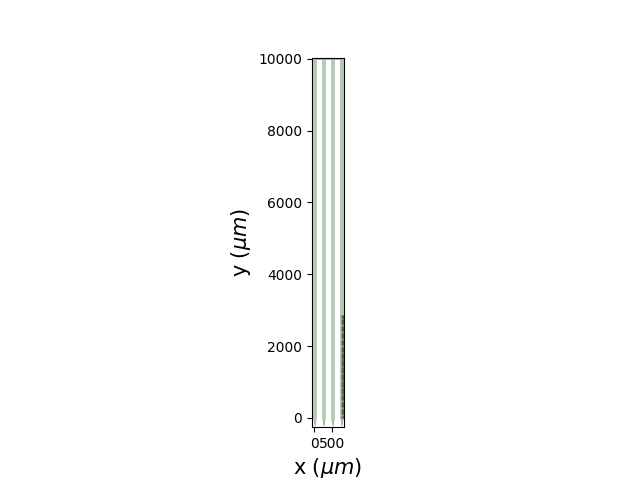

In [9]:
%matplotlib widget
si.plot_probe_map(recording)

And we can plot the raw traces. Note that not all data gets loaded (it's a 90GB file: it would crash my machine!): only the data in the `time_range` is loaded.

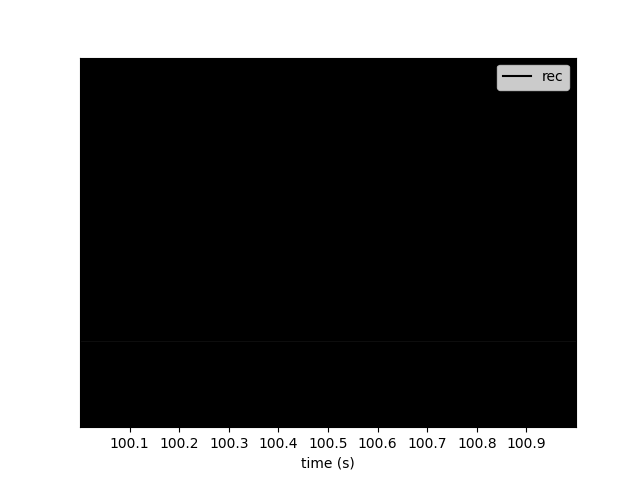

In [10]:
si.plot_traces(
    recording,
    mode="line",  # plot the traces as lines, rather than a heatmap
    time_range = (100,101),
)

Hmmm... that doesn't look helpful. We can _slice_ our recording to focus on a small bit of it; either in time or in channels.

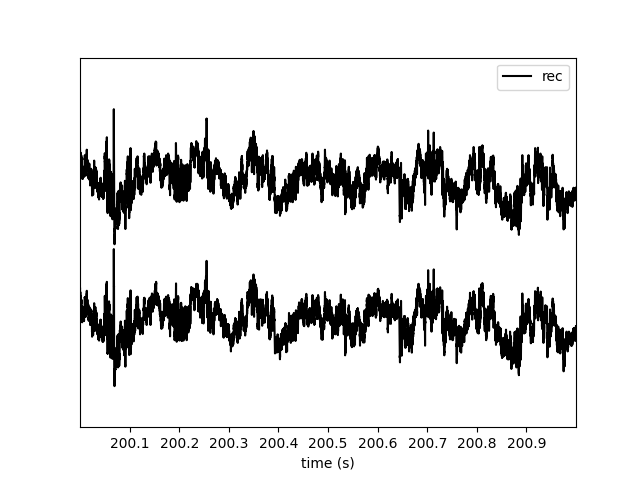

In [11]:
time_sliced_recording = recording.time_slice(start_time=200, end_time=250)
channel_sliced_recording = time_sliced_recording.select_channels(channel_ids=['CH1', 'CH2'])
# Note: you can also remove chanels using `recording.remove_channels(...)

si.plot_traces(channel_sliced_recording)

# Generating your own Probe

OpenEphys NeuroPixels data is great: the probe is auto-generated when you load in the data.

But that's not always the case.

Suppose you have a custom probe with 4-shanks, with 8 channels on each shank. We can generate some artificial data to imitate this scenario

In [12]:
fake_recording = si.generate_recording(
    num_channels = 4*8,
    durations = [300],
    set_probe=False,
)

print(fake_recording.has_probe())

False


We can make a probe by creating a `Probe` object from `ProbeInterface`. At a minimum, this needs the locations of each channel. Read more in the ProbeInterface docs (https://probeinterface.readthedocs.io/en/stable/index.html)

In [13]:
import numpy as np

positions_on_one_shank = np.array([
    [0,0],
    [20,0],
    [0,20],
    [20,20],
    [0,40],
    [20,40],
    [0,60],
    [20,60],
])

all_positions = np.concatenate([
    positions_on_one_shank, 
    positions_on_one_shank+[100,0], 
    positions_on_one_shank+[200,0], 
    positions_on_one_shank+[300,0]
])

In [14]:
from probeinterface import Probe
probe = Probe(ndim=2, si_units='um')
probe.set_contacts(positions=all_positions)

# We need to "wire" the probe, to say which channel corresponds to which column in the raw traces file. 
probe.set_device_channel_indices(range(0,4*8))

# And we'll make an auto-shape in the hope of making prettier plots
probe.create_auto_shape()

In [15]:
recording_with_probe = fake_recording.set_probe(probe)

In [16]:
recording_with_probe

SyntheticRecording (NoiseGeneratorRecording): 32 channels - 30.0kHz - 1 segments 
                    9,000,000 samples - 300.00s (5.00 minutes) - float32 dtype - 1.07 GiB

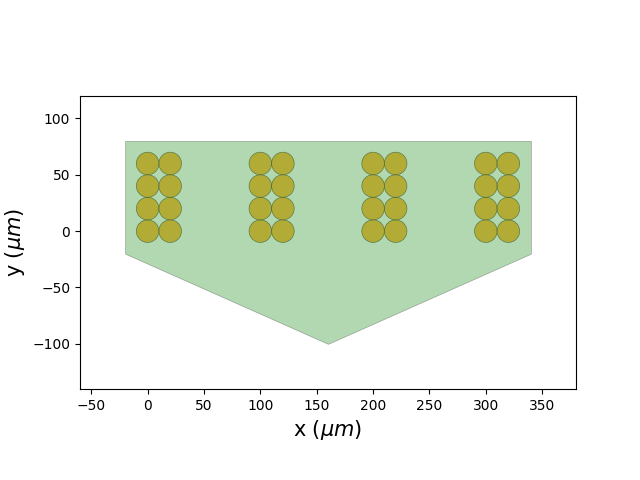

In [17]:
si.plot_probe_map(recording_with_probe)

These four shanks are far apart from each other, and we might want to deal with them independently. We can set a "group" property to each electrode:

In [18]:
recording_with_probe.set_channel_groups([0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3])

We can then split the recording using the `split_by` method:

In [19]:
grouped_recordings = recording_with_probe.split_by('group')
grouped_recordings

{0: SyntheticRecording (ChannelSliceRecording): 8 channels - 30.0kHz - 1 segments - 9,000,000 samples 
                     300.00s (5.00 minutes) - float32 dtype - 274.66 MiB,
 1: SyntheticRecording (ChannelSliceRecording): 8 channels - 30.0kHz - 1 segments - 9,000,000 samples 
                     300.00s (5.00 minutes) - float32 dtype - 274.66 MiB,
 2: SyntheticRecording (ChannelSliceRecording): 8 channels - 30.0kHz - 1 segments - 9,000,000 samples 
                     300.00s (5.00 minutes) - float32 dtype - 274.66 MiB,
 3: SyntheticRecording (ChannelSliceRecording): 8 channels - 30.0kHz - 1 segments - 9,000,000 samples 
                     300.00s (5.00 minutes) - float32 dtype - 274.66 MiB}

As we'll see later, many of `SpikeInterface`'s functions work exactly the same way with a recording, or a group of recordings (like the one above)

`ProbeInterface` also has some helper probe creation functions such as `generate_multi_shank` and `generate_linear`. Read more in the docs: https://probeinterface.readthedocs.io/en/stable/index.html

There is also a library of probes you can load in (https://probeinterface.readthedocs.io/en/stable/examples/ex_10_get_probe_from_library.html), mostly from Cambridge Neurotech and NeuroNexus.

`SpikeInterface` also contains some pretty advanced generation tools. We can make fake data that imitates a multi-shank recording like so

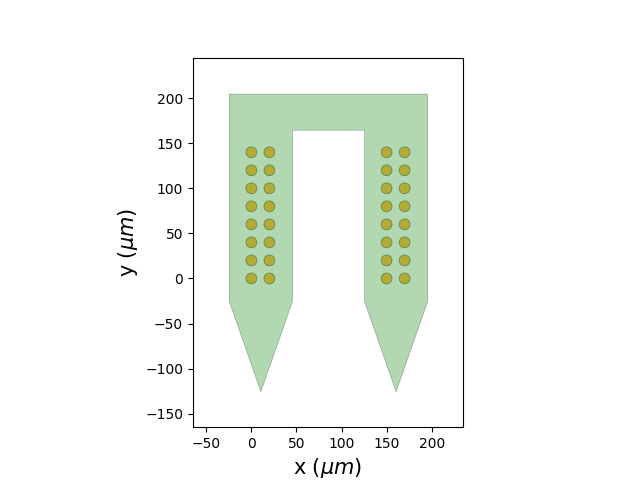

In [20]:
from probeinterface import generate_multi_shank
two_shank_probe = generate_multi_shank(num_shank=2, num_contact_per_column=8, num_columns=2)
two_shank_probe.set_device_channel_indices(range(32))
si_generated_recording, _ = si.generate_ground_truth_recording(
    durations=[300],
    num_channels=32,
    probe=two_shank_probe
)
si.plot_probe_map(si_generated_recording)

# Saving a representation of a Recording

You'll hear more about saving recordings later. For now, we'll save a `.json` file that represents this generated probe.

In [21]:
path_to_json = results_folder / 'recording.json'
path_to_json.parent.mkdir(exist_ok=True, parents=True)
recording.dump_to_json(path_to_json)

This `json` file is a lightweight representation of the recording, but it just links to the raw recording. Hence you can open it and find out all about the probe, any preprocessing that's been done, and more, without taking up lots of space on your hard drive. Go take a look at the file.